# mini-MIAS data preprocessing

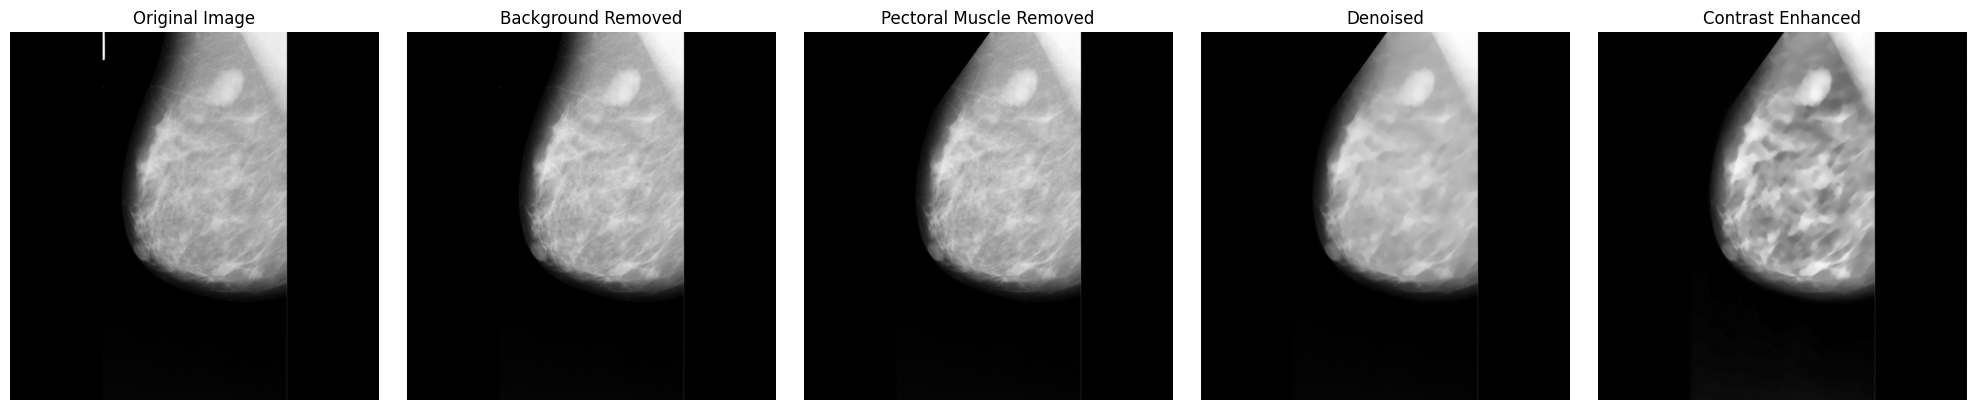

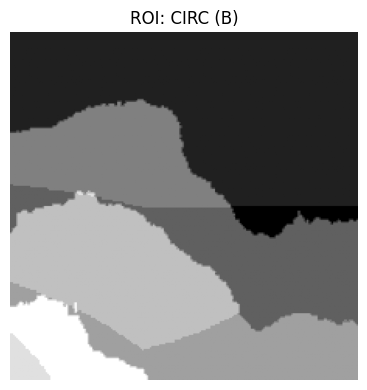

Processing images:  11%|██████▌                                                       | 25/237 [00:07<01:05,  3.25it/s]

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import glob
from scipy import ndimage
from sklearn.linear_model import RANSACRegressor

class MammogramPreprocessor:
    def __init__(self, image_dir, metadata_path, output_dir, img_size=(224, 224)):
        """
        Initialize the mammogram preprocessor.
        
        Args:
            image_dir: Directory containing the mini-MIAS images
            metadata_path: Path to the CSV file with metadata
            output_dir: Directory to save processed images
            img_size: Target size for the processed images
        """
        self.image_dir = image_dir
        self.metadata_path = metadata_path
        self.output_dir = output_dir
        self.img_size = img_size
        
        # Create output directories if they don't exist
        os.makedirs(os.path.join(output_dir, "processed_images"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "roi_images"), exist_ok=True)
        
        # Load metadata
        self.metadata = pd.read_csv(metadata_path)
        
        # Create a dictionary for quick lookup of image metadata
        self.image_metadata = {}
        for _, row in self.metadata.iterrows():
            ref_num = row['REFNUM']
            if ref_num not in self.image_metadata:
                self.image_metadata[ref_num] = []
            
            # Only add entries with abnormalities (those with coordinates)
            if not pd.isna(row['X']) and not pd.isna(row['Y']) and not pd.isna(row['RADIUS']):
                self.image_metadata[ref_num].append({
                    'x': int(row['X']),
                    'y': int(row['Y']),
                    'radius': int(row['RADIUS']),
                    'class': row['CLASS'],
                    'severity': row['SEVERITY'] if not pd.isna(row['SEVERITY']) else None,
                    'bg': row['BG']  # Breast density type
                })
    
    def load_image(self, image_path):
        """Load an image and convert to grayscale if needed."""
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        # Convert to grayscale if the image is color
        if len(img.shape) > 2 and img.shape[2] > 1:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        return img
    
    def remove_background(self, img):
        """Advanced background removal with adaptive thresholding."""
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        
        # Apply adaptive thresholding
        binary = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
            cv2.THRESH_BINARY, 11, 2
        )
        
        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Create a mask with the largest contour (breast region)
        mask = np.zeros_like(img)
        if contours:
            # Find the largest contour (breast region)
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Fill the contour with white
            cv2.drawContours(mask, [largest_contour], 0, 255, -1)
            
            # Apply morphological operations to smooth the mask edges
            kernel = np.ones((7, 7), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
            
            # Create a completely black background image
            result = np.zeros_like(img)
            
            # Copy only the breast region to the result
            np.copyto(result, img, where=(mask > 0))
            
            # Final cleanup - ensure all background is truly black
            result[mask == 0] = 0
            
            return result, mask
        
        return img, np.ones_like(img) * 255

    
    def remove_pectoral_muscle(self, img, mask=None):
        """
        Remove the pectoral muscle from the mammogram with extremely aggressive removal.
        
        This implementation prioritizes complete removal of the pectoral muscle,
        particularly for images with larger pectoral regions.
        
        Args:
            img: Input mammogram image
            mask: Optional breast region mask
            
        Returns:
            Image with pectoral muscle removed
        """
        if img is None:
            return None
        
        # Create a copy of the image
        result = img.copy()
        height, width = img.shape
        
        # Determine if the breast is on the left or right side
        if mask is None:
            # Create a simple mask if none is provided
            _, simple_mask = cv2.threshold(img, 5, 255, cv2.THRESH_BINARY)
            mask = simple_mask
        
        left_sum = np.sum(mask[:, :mask.shape[1]//2])
        right_sum = np.sum(mask[:, mask.shape[1]//2:])
        is_left_breast = left_sum > right_sum
        
        try:
            # Step 1: Define a very large region of interest for pectoral muscle
            # Use a much larger portion of the image to ensure we capture the entire pectoral muscle
            pectoral_height = int(height * 0.72)  # Increased from 0.6 to 0.7
            pectoral_width = int(width * 0.52)    # Increased from 0.4 to 0.5
            
            # Extract the pectoral muscle region
            if is_left_breast:
                pectoral_region = img[0:pectoral_height, 0:pectoral_width]
                x_offset, y_offset = 0, 0
            else:
                pectoral_region = img[0:pectoral_height, width-pectoral_width:width]
                x_offset, y_offset = width-pectoral_width, 0
            
            # Check if pectoral region is valid
            if pectoral_region.size == 0 or np.max(pectoral_region) == 0:
                return img  # Return original image if pectoral region is invalid
            
            # Step 2: Create a very aggressive triangular mask
            # This is our primary approach - a geometric mask that covers the typical pectoral region
            pectoral_mask = np.zeros_like(pectoral_region)
            
            # Calculate the slope for the triangular mask based on image dimensions
            # This creates an extremely aggressive triangle that covers more of the pectoral region
            if is_left_breast:
                # For left breast, create a triangle from top-left corner
                # Use a much more aggressive slope
                for y in range(pectoral_height):
                    # Quadratic function for more aggressive coverage at the top
                    width_at_y = int(pectoral_width * (1 - (y / pectoral_height)))
                    pectoral_mask[y, 0:width_at_y] = 255
            else:
                # For right breast, create a triangle from top-right corner
                for y in range(pectoral_height):
                    # Quadratic function for more aggressive coverage at the top
                    width_at_y = int(pectoral_width * (1 - (y / pectoral_height)))
                    pectoral_mask[y, pectoral_width-width_at_y:pectoral_width] = 255
            
            # Step 3: Apply morphological operations to ensure complete coverage
            kernel = np.ones((5, 5), np.uint8)  # Much larger kernel for aggressive morphology
            pectoral_mask = cv2.morphologyEx(pectoral_mask, cv2.MORPH_DILATE, kernel)
            
            # Step 4: Create a full-sized mask
            full_mask = np.zeros_like(img)
            full_mask[y_offset:y_offset+pectoral_height, x_offset:x_offset+pectoral_width] = pectoral_mask
            
            # Step 5: Apply a straight line boundary for a clean edge
            # Instead of detecting the edge, we'll create a straight line from top to bottom
            # This ensures a consistent, clean removal
            
            # Define the line parameters based on breast orientation
            if is_left_breast:
                top_x = int(width * 0.35)     # Increase from 0.25 to 0.35 or 0.4
                bottom_x = int(width * 0.08)  # Increase from 0.05 to 0.08
            else:
                top_x = int(width * 0.65)     # Decrease from 0.75 to 0.65 or 0.6
                bottom_x = int(width * 0.92)  # Decrease from 0.95 to 0.92
            
            # Create a refined mask with the straight line
            refined_mask = np.zeros_like(img)
            
            # Draw the line and fill the appropriate side
            for y in range(height):
                # Linear interpolation between top_x and bottom_x
                x_line = int(top_x + (bottom_x - top_x) * (y / height))
                
                if is_left_breast:
                    x_range = range(0, min(x_line, width))
                else:
                    x_range = range(max(0, x_line), width)
                
                for x in x_range:
                    refined_mask[y, x] = 255
            
            # Step 6: Combine the triangular mask with the straight line mask
            # Use the most aggressive of the two approaches
            combined_mask = cv2.bitwise_or(full_mask, refined_mask)
            
            # Invert the mask to keep everything except the pectoral muscle
            final_mask = cv2.bitwise_not(combined_mask)
            
            # Step 7: Apply the mask to the original image
            result = cv2.bitwise_and(img, img, mask=final_mask)
            
            # Step 8: Post-processing for smooth transition
            # Create a gradient mask for the boundary
            gradient_mask = cv2.GaussianBlur(final_mask, (31, 31), 0)  # Very large blur for smoother transition
            
            # Apply the gradient mask for smooth transition
            result = cv2.bitwise_and(img, img, mask=gradient_mask)
            
            return result
            
        except Exception as e:
            print(f"Error in pectoral muscle removal: {e}")
            # Return the original image if any error occurs
            return img

    
    def enhance_contrast(self, img):
        """Enhance the contrast of the image using CLAHE."""
        # Create a CLAHE object
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        
        # Apply CLAHE
        enhanced = clahe.apply(img)
        
        return enhanced
    
    def extract_roi(self, img, x, y, radius, padding=10):
        """Extract a region of interest around a suspicious area."""
        # Add padding to the radius
        padded_radius = radius + padding
        
        # Calculate the bounding box
        x1 = max(0, x - padded_radius)
        y1 = max(0, y - padded_radius)
        x2 = min(img.shape[1], x + padded_radius)
        y2 = min(img.shape[0], y + padded_radius)
        
        # Extract the ROI
        roi = img[y1:y2, x1:x2]
        
        # Resize the ROI to the target size
        roi_resized = cv2.resize(roi, self.img_size)
        
        return roi_resized
    
    def normalize_image(self, img):
        """Normalize the image to [0, 1] range."""
        # Handle case where image is all zeros
        if np.max(img) == 0:
            return img
        
        normalized = img.astype(np.float32) / 255.0
        return normalized
    
    def denoise_image(self, img):
        """Apply denoising to the image."""
        # Apply non-local means denoising
        denoised = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
        return denoised
    
    def process_image(self, image_path, save=True):
        """Process a single mammogram image with pectoral removal first."""
        # Extract the image reference number from the filename
        filename = os.path.basename(image_path)
        ref_num = os.path.splitext(filename)[0]
        
        # Load the image
        original_img = self.load_image(image_path)
        
        # First create a simple mask to determine breast orientation
        _, simple_mask = cv2.threshold(original_img, 5, 255, cv2.THRESH_BINARY)
        
        # Remove pectoral muscle first
        img_no_pectoral = self.remove_pectoral_muscle(original_img, simple_mask)
        
        # Then remove background
        img_no_bg, mask = self.remove_background(img_no_pectoral)
        
        # Denoise the image
        img_denoised = self.denoise_image(img_no_bg)
        
        # Enhance contrast
        img_enhanced = self.enhance_contrast(img_denoised)
        
        # Normalize the image
        img_normalized = self.normalize_image(img_enhanced)
        
        # Resize the image to the target size
        img_resized = cv2.resize(img_enhanced, self.img_size)
        
        # Save the processed image
        if save:
            output_path = os.path.join(self.output_dir, "processed_images", f"{ref_num}_processed.png")
            cv2.imwrite(output_path, img_resized)
        
        # Extract ROIs if abnormalities exist
        rois = []
        if ref_num in self.image_metadata and self.image_metadata[ref_num]:
            for abnormality in self.image_metadata[ref_num]:
                x, y, radius = abnormality['x'], abnormality['y'], abnormality['radius']
                roi = self.extract_roi(img_enhanced, x, y, radius)
                
                if save:
                    roi_path = os.path.join(self.output_dir, "roi_images", 
                                           f"{ref_num}_roi_x{x}_y{y}_r{radius}.png")
                    cv2.imwrite(roi_path, roi)
                
                rois.append({
                    'roi': roi,
                    'metadata': abnormality
                })
        
        return {
            'ref_num': ref_num,
            'processed_image': img_resized,
            'rois': rois,
            'has_abnormality': len(rois) > 0
        }

    
    def process_all_images(self):
        """Process all images in the dataset."""
        image_paths = glob.glob(os.path.join(self.image_dir, "*.png"))
        if not image_paths:
            image_paths = glob.glob(os.path.join(self.image_dir, "*.pgm"))
        
        results = []
        for image_path in tqdm(image_paths, desc="Processing images"):
            try:
                result = self.process_image(image_path)
                results.append(result)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
        
        return results
    
    def create_dataset(self):
        """Create a dataset for training a CNN."""
        processed_data = self.process_all_images()
        
        # Separate normal and abnormal cases
        normal_cases = [data for data in processed_data if not data['has_abnormality']]
        abnormal_cases = [data for data in processed_data if data['has_abnormality']]
        
        # Create X (images) and y (labels)
        X = []
        y = []
        
        # Add normal cases
        for case in normal_cases:
            X.append(case['processed_image'])
            y.append(0)  # 0 for normal
        
        # Add abnormal cases
        for case in abnormal_cases:
            X.append(case['processed_image'])
            y.append(1)  # 1 for abnormal
            
            # Also add ROIs as separate samples
            for roi_data in case['rois']:
                X.append(roi_data['roi'])
                # If you want to differentiate between benign and malignant:
                if roi_data['metadata']['severity'] == 'M':
                    y.append(2)  # 2 for malignant
                else:
                    y.append(1)  # 1 for benign
        
        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        # Split into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        return X_train, X_val, y_train, y_val
    
    def visualize_preprocessing(self, image_path):
        """Visualize the preprocessing steps for a single image."""
        # Load the image
        original_img = self.load_image(image_path)
        
        # Remove background
        img_no_bg, mask = self.remove_background(original_img)
        
        # Remove pectoral muscle
        img_no_pectoral = self.remove_pectoral_muscle(img_no_bg, mask)
        
        # Denoise the image
        img_denoised = self.denoise_image(img_no_pectoral)
        
        # Enhance contrast
        img_enhanced = self.enhance_contrast(img_denoised)
        
        # Create a figure to display the preprocessing steps
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        
        axes[0].imshow(original_img, cmap='gray')
        axes[0].set_title('Original Image')
        
        axes[1].imshow(img_no_bg, cmap='gray')
        axes[1].set_title('Background Removed')
        
        axes[2].imshow(img_no_pectoral, cmap='gray')
        axes[2].set_title('Pectoral Muscle Removed')
        
        axes[3].imshow(img_denoised, cmap='gray')
        axes[3].set_title('Denoised')
        
        axes[4].imshow(img_enhanced, cmap='gray')
        axes[4].set_title('Contrast Enhanced')
        
        for ax in axes:
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Extract the image reference number from the filename
        filename = os.path.basename(image_path)
        ref_num = os.path.splitext(filename)[0]
        
        # Visualize ROIs if abnormalities exist
        if ref_num in self.image_metadata and self.image_metadata[ref_num]:
            fig, axes = plt.subplots(1, len(self.image_metadata[ref_num]), figsize=(4*len(self.image_metadata[ref_num]), 4))
            
            # Handle the case where there's only one abnormality
            if len(self.image_metadata[ref_num]) == 1:
                axes = [axes]
            
            for i, abnormality in enumerate(self.image_metadata[ref_num]):
                x, y, radius = abnormality['x'], abnormality['y'], abnormality['radius']
                roi = self.extract_roi(img_enhanced, x, y, radius)
                
                axes[i].imshow(roi, cmap='gray')
                axes[i].set_title(f"ROI: {abnormality['class']} ({abnormality['severity']})")
                axes[i].axis('off')
            
            plt.tight_layout()
            plt.show()


def data_augmentation(X_train, y_train, augmentation_factor=2):
    """
    Apply data augmentation to the training set.
    
    Args:
        X_train: Training images
        y_train: Training labels
        augmentation_factor: How many times to augment the dataset
        
    Returns:
        Augmented training set
    """
    X_augmented = []
    y_augmented = []
    
    # Add original data
    X_augmented.extend(X_train)
    y_augmented.extend(y_train)
    
    for i in range(len(X_train)):
        img = X_train[i]
        label = y_train[i]
        
        # Only augment abnormal cases (label > 0) more extensively
        aug_factor = augmentation_factor if label > 0 else 1
        
        for _ in range(aug_factor):
            # Randomly choose augmentation techniques
            augmentation_type = np.random.choice(['flip', 'rotate', 'zoom', 'noise'])
            
            if augmentation_type == 'flip':
                # Horizontal flip
                augmented_img = cv2.flip(img, 1)
            
            elif augmentation_type == 'rotate':
                # Random rotation between -15 and 15 degrees
                angle = np.random.uniform(-15, 15)
                augmented_img = ndimage.rotate(img, angle, reshape=False)
            
            elif augmentation_type == 'zoom':
                # Random zoom between 0.9 and 1.1
                zoom_factor = np.random.uniform(0.9, 1.1)
                h, w = img.shape[:2]
                
                # Calculate new dimensions
                new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
                
                # Resize the image
                if zoom_factor < 1.0:  # Zoom out
                    augmented_img = cv2.resize(img, (new_w, new_h))
                    # Pad to original size
                    pad_h = (h - new_h) // 2
                    pad_w = (w - new_w) // 2
                    augmented_img = cv2.copyMakeBorder(
                        augmented_img, pad_h, h - new_h - pad_h, pad_w, w - new_w - pad_w,
                        cv2.BORDER_CONSTANT, value=0
                    )
                else:  # Zoom in
                    # Crop the center
                    start_h = (h - new_h) // 2
                    start_w = (w - new_w) // 2
                    end_h = start_h + new_h
                    end_w = start_w + new_w
                    cropped = img[max(0, start_h):min(h, end_h), max(0, start_w):min(w, end_w)]
                    augmented_img = cv2.resize(cropped, (w, h))
            
            elif augmentation_type == 'noise':
                # Add Gaussian noise
                mean = 0
                stddev = np.random.uniform(0.01, 0.05)
                noise = np.random.normal(mean, stddev, img.shape).astype(np.float32)
                augmented_img = np.clip(img + noise, 0, 1).astype(np.float32)
            
            X_augmented.append(augmented_img)
            y_augmented.append(label)
    
    return np.array(X_augmented), np.array(y_augmented)


# Define paths
image_dir = "C:/Users/DragosTrandafiri/BreastCancer_CNN/data/raw/mini_mias/MIAS" 
metadata_path = "C:/Users/DragosTrandafiri/BreastCancer_CNN/data/raw/mini_mias/mias_info.csv"  
output_dir = "C:/Users/DragosTrandafiri/BreastCancer_CNN/data/processed/mini_mias"

# Create preprocessor
preprocessor = MammogramPreprocessor(image_dir, metadata_path, output_dir)

# Visualize preprocessing for a sample image
sample_image_path = os.path.join(image_dir, "mdb015.png")  # Replace with an actual image path
preprocessor.visualize_preprocessing(sample_image_path)

# Create dataset
X_train, X_val, y_train, y_val = preprocessor.create_dataset()

# Apply data augmentation
X_train_aug, y_train_aug = data_augmentation(X_train, y_train)

print(f"Original training set: {X_train.shape}, {y_train.shape}")
print(f"Augmented training set: {X_train_aug.shape}, {y_train_aug.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")


In [1]:
!pip install opencv-python
!pip install numpy pandas matplotlib scikit-learn tqdm scipy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
